In [1]:
import json
import pandas as pd
import preprocessor as p
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

import spacy

In [1]:
import nltk
import pandas as pd
import numpy as np
import json
from collections import Counter
import re, string, unicodedata

from nltk import FreqDist

import matplotlib.pyplot as plt #For graphics
import wordcloud #Makes word clouds
import numpy as np #For divergences/distances
import scipy #For divergences/distances
import seaborn as sns 
import sklearn.manifold #For a manifold plot
import json #For API responses
import urllib.parse #For joining urls

import spacy

#Displays the graphs
import graphviz #You also need to install the command line graphviz

#These are from the standard library
import os.path
import zipfile
import subprocess
import io
import tempfile

import matplotlib.pyplot as plt
import matplotlib
import keras

#This 'magic' command makes the plots work better
# in the notebook, don't use it outside of a notebook
%matplotlib inline

In [2]:
try:
    nlp = spacy.load("en")
except OSError:
    nlp = spacy.load("en_core_web_sm")

In [3]:
tweets = []
for line in open('data/cdc_twitter_covid.json', 'r', encoding='utf-8'):
    tweets.append(json.loads(line))
    
df = pd.DataFrame(tweets)

In [4]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

In [5]:
df = df[['id', 'date', 'time', 'username', 'tweet', 'mentions','urls', 'photos', 'hashtags', 'link', 'quote_url']]

In [6]:
tweets_df = df[['id', 'date', 'time', 'username', 'tweet', 'hashtags']]
tweets_df

,id,date,time,username,tweet,hashtags
0,1363921515922796547,2021-02-22,13:40:04,cdcgov,#DYK? COVID-19 and flu can both cause fever an...,"[dyk, covid19]"
1,1363885801755533313,2021-02-22,11:18:09,cdcgov,A new @CDCMMWR looks at #COVID19 in Georgia el...,[covid19]
2,1362865816765661190,2021-02-19,15:45:06,cdcgov,Officials are concerned about 3 #COVID19 varia...,[covid19]
3,1362849192130080772,2021-02-19,14:39:02,cdcgov,Getting a #COVID19 vaccine is important for ad...,[covid19]
4,1362510972162867206,2021-02-18,16:15:04,cdcgov,#DYK? You need two #COVID19 mRNA vaccine doses...,"[dyk, covid19]"
...,...,...,...,...,...,...
426,1233891883195211780,2020-02-29,18:08:44,cdcgov,Reports of community spread of #COVID19 in Cal...,[covid19]
427,1233891113628557313,2020-02-29,18:05:40,cdcgov,"CDC, @WADeptHealth &amp; @KCPubHealth also rep...",[covid]
428,1233891108654108672,2020-02-29,18:05:39,cdcgov,"Today, @WADeptHealth and CDC reported the deat...","[covid, coronavirus]"
429,1233486735578976257,2020-02-28,15:18:49,cdcgov,CDC does not currently recommend the general p...,"[covid19, ppe]"


In [7]:
print('--- Print the Basic Info of the data ----')
print(tweets_df.info())
print(tweets_df.shape)

print('--- Print the Head/Tail of the data -----')
print(tweets_df.head())
print('------------------------')
print(tweets_df.tail())

--- Print the Basic Info of the data ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        431 non-null    int64 
 1   date      431 non-null    object
 2   time      431 non-null    object
 3   username  431 non-null    object
 4   tweet     431 non-null    object
 5   hashtags  431 non-null    object
dtypes: int64(1), object(5)
memory usage: 20.3+ KB
None
(431, 6)
--- Print the Head/Tail of the data -----
                    id        date      time username  \
0  1363921515922796547  2021-02-22  13:40:04   cdcgov   
1  1363885801755533313  2021-02-22  11:18:09   cdcgov   
2  1362865816765661190  2021-02-19  15:45:06   cdcgov   
3  1362849192130080772  2021-02-19  14:39:02   cdcgov   
4  1362510972162867206  2021-02-18  16:15:04   cdcgov   

                                               tweet        hashtags  
0  #DYK? COVID-19 and flu can

In [8]:
# remove URLs, emojis, smileys, mentions, hashtags, and reserved words
for i,v in enumerate(tweets_df['tweet']):
#     p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.SMILEY, p.OPT.MENTION, p.OPT.HASHTAG, p.OPT.RESERVED) # options: p.OPT.URL, p.OPT.MENTION, p.OPT.HASHTAG,
                                                                                                #p.OPT.RESERVED, p.OPT.EMOJI, p.OPT.SMILEY,
                                                                                                #p.OPT.NUMBER
    tweets_df.loc[i, 'tweet'] = p.clean(v)
    tweets_df.loc[i, 'tweet'] = tweets_df.loc[i, "tweet"]

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\indexing.py:1719: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [9]:
tweets_df.loc[0, "tweet"]

'? COVID-19 and flu can both cause fever and cough, but shortness of breath is more common with than flu. Use this chart to learn more about the similarities and differences of COVID-19 and flu. Learn more: .'

In [10]:
# Remove extra white spaces, punctuation and apply lower casing
tweets_df['tweet'] = tweets_df['tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')
tweets_df.loc[0, "tweet"]

<ipython-input-10-e68e07bc12be>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_df['tweet'] = tweets_df['tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')
<ipython-input-10-e68e07bc12be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['tweet'] = tweets_df['tweet'].str.lower().str.replace('[^\w\s]',' ').str.replace('\s\s+', ' ')


' covid 19 and flu can both cause fever and cough but shortness of breath is more common with than flu use this chart to learn more about the similarities and differences of covid 19 and flu learn more '

In [11]:
# lemmatize and tokenize
def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):   
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [12]:
def normalizeTokens(word_list, extra_stop=[], model=nlp, lemma=True, MAX_LEN=1500000):
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    # since we're only normalizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list.lower(), disable=["parser", "tagger", "ner"])

    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    # check if we want lemmas or not earlier to avoid checking every time we loop
    if lemma:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(str(w.lemma_))
    else:
        for w in doc:
            # if it's not a stop word or punctuation mark, add it to our article
            if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
                normalized.append(str(w.text.strip()))

    return normalized

In [13]:
tweets_df['tokenized_tweet'] = tweets_df['tweet'].apply(lambda x: word_tokenize(x))
tweets_df['normalized_tokens'] = tweets_df['tokenized_tweet'].apply(lambda x: normalizeTokens(x))

<ipython-input-13-8fcd6026113e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['tokenized_tweet'] = tweets_df['tweet'].apply(lambda x: word_tokenize(x))
<ipython-input-13-8fcd6026113e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['normalized_tokens'] = tweets_df['tokenized_tweet'].apply(lambda x: normalizeTokens(x))


In [14]:
tweets_df

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens
0,1363921515922796547,2021-02-22,13:40:04,cdcgov,covid 19 and flu can both cause fever and cou...,"[dyk, covid19]","[covid, 19, and, flu, can, both, cause, fever,...","[covid, flu, cause, fever, cough, shortness, b..."
1,1363885801755533313,2021-02-22,11:18:09,cdcgov,a new looks at in georgia elementary schools t...,[covid19],"[a, new, looks, at, in, georgia, elementary, s...","[new, look, georgia, elementary, school, study..."
2,1362865816765661190,2021-02-19,15:45:06,cdcgov,officials are concerned about variants detecte...,[covid19],"[officials, are, concerned, about, variants, d...","[official, concern, variant, detect, u, s, b, ..."
3,1362849192130080772,2021-02-19,14:39:02,cdcgov,getting a vaccine is important for adults with...,[covid19],"[getting, a, vaccine, is, important, for, adul...","[get, vaccine, important, adult, certain, heal..."
4,1362510972162867206,2021-02-18,16:15:04,cdcgov,you need two mrna vaccine doses to get the mo...,"[dyk, covid19]","[you, need, two, mrna, vaccine, doses, to, get...","[need, mrna, vaccine, dose, protection, covid,..."
...,...,...,...,...,...,...,...,...
426,1233891883195211780,2020-02-29,18:08:44,cdcgov,reports of community spread of in california o...,[covid19],"[reports, of, community, spread, of, in, calif...","[report, community, spread, california, oregon..."
427,1233891113628557313,2020-02-29,18:05:40,cdcgov,cdc amp also reported ppl have tested positive...,[covid],"[cdc, amp, also, reported, ppl, have, tested, ...","[cdc, amp, report, ppl, test, positive, hospit..."
428,1233891108654108672,2020-02-29,18:05:39,cdcgov,today and cdc reported the death of a person w...,"[covid, coronavirus]","[today, and, cdc, reported, the, death, of, a,...","[today, cdc, report, death, person, hospitaliz..."
429,1233486735578976257,2020-02-28,15:18:49,cdcgov,cdc does not currently recommend the general p...,"[covid19, ppe]","[cdc, does, not, currently, recommend, the, ge...","[cdc, currently, recommend, general, public, u..."


In [15]:
# save tweets as txt file
#tweets_df["tweet"].to_csv("tweet" + '.txt', index=False)

In [16]:
tweets_df['year'] = tweets_df['date'].apply(lambda x: x.split('-')[0])
tweets_df['month'] = tweets_df['date'].apply(lambda x: x.split('-')[1])
tweets_df['date'] = tweets_df['date'].apply(lambda x: x.split('-')[2])

<ipython-input-16-fc52ba283241>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['year'] = tweets_df['date'].apply(lambda x: x.split('-')[0])
<ipython-input-16-fc52ba283241>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_df['month'] = tweets_df['date'].apply(lambda x: x.split('-')[1])
<ipython-input-16-fc52ba283241>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [17]:
tweets_df

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month
0,1363921515922796547,22,13:40:04,cdcgov,covid 19 and flu can both cause fever and cou...,"[dyk, covid19]","[covid, 19, and, flu, can, both, cause, fever,...","[covid, flu, cause, fever, cough, shortness, b...",2021,02
1,1363885801755533313,22,11:18:09,cdcgov,a new looks at in georgia elementary schools t...,[covid19],"[a, new, looks, at, in, georgia, elementary, s...","[new, look, georgia, elementary, school, study...",2021,02
2,1362865816765661190,19,15:45:06,cdcgov,officials are concerned about variants detecte...,[covid19],"[officials, are, concerned, about, variants, d...","[official, concern, variant, detect, u, s, b, ...",2021,02
3,1362849192130080772,19,14:39:02,cdcgov,getting a vaccine is important for adults with...,[covid19],"[getting, a, vaccine, is, important, for, adul...","[get, vaccine, important, adult, certain, heal...",2021,02
4,1362510972162867206,18,16:15:04,cdcgov,you need two mrna vaccine doses to get the mo...,"[dyk, covid19]","[you, need, two, mrna, vaccine, doses, to, get...","[need, mrna, vaccine, dose, protection, covid,...",2021,02
...,...,...,...,...,...,...,...,...,...,...
426,1233891883195211780,29,18:08:44,cdcgov,reports of community spread of in california o...,[covid19],"[reports, of, community, spread, of, in, calif...","[report, community, spread, california, oregon...",2020,02
427,1233891113628557313,29,18:05:40,cdcgov,cdc amp also reported ppl have tested positive...,[covid],"[cdc, amp, also, reported, ppl, have, tested, ...","[cdc, amp, report, ppl, test, positive, hospit...",2020,02
428,1233891108654108672,29,18:05:39,cdcgov,today and cdc reported the death of a person w...,"[covid, coronavirus]","[today, and, cdc, reported, the, death, of, a,...","[today, cdc, report, death, person, hospitaliz...",2020,02
429,1233486735578976257,28,15:18:49,cdcgov,cdc does not currently recommend the general p...,"[covid19, ppe]","[cdc, does, not, currently, recommend, the, ge...","[cdc, currently, recommend, general, public, u...",2020,02


In [18]:
%store tweets_df

Stored 'tweets_df' (DataFrame)


In [19]:
#save cleaned texts as txt file
tweets_df.to_csv("cleaned_tweets" + '.txt', index=False)

In [20]:
tweets01 = tweets_df[((tweets_df["month"] == '02') |(tweets_df["month"] == '03')) & (tweets_df["year"] == '2020')]
tweets01 = tweets01.reset_index(drop=True)
tweets01

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month
0,1244692113448677378,30,14:24:59,cdcgov,asymptomatic and pre symptomatic nursing home ...,[],"[asymptomatic, and, pre, symptomatic, nursing,...","[asymptomatic, pre, symptomatic, nurse, home, ...",2020,03
1,1244349105343774720,29,15:42:00,cdcgov,take simple daily precautions to help prevent ...,[covid19],"[take, simple, daily, precautions, to, help, p...","[simple, daily, precaution, help, prevent, spr...",2020,03
2,1243960241311678465,28,13:56:47,cdcgov,new cdc health alert network advisory severe i...,[coronavirus],"[new, cdc, health, alert, network, advisory, s...","[new, cdc, health, alert, network, advisory, s...",2020,03
3,1243215392929185794,26,12:37:02,cdcgov,parents stay flexible with a learning schedule...,[],"[parents, stay, flexible, with, a, learning, s...","[parent, stay, flexible, learn, schedule, kid,...",2020,03
4,1242915042049351682,25,16:43:32,cdcgov,as of march us states and us territory report ...,"[coronavirus, covid19]","[as, of, march, us, states, and, us, territory...","[march, state, territory, report, community, s...",2020,03
5,1242147859178360834,23,13:55:02,cdcgov,cdc recommends that travelers defer all cruise...,[covid19],"[cdc, recommends, that, travelers, defer, all,...","[cdc, recommend, traveler, defer, cruise, trav...",2020,03
6,1241815661648596994,22,15:55:00,cdcgov,we all have a role to play to reducing and slo...,"[covid19, stayathome]","[we, all, have, a, role, to, play, to, reducin...","[role, play, reduce, slow, transmission, physi...",2020,03
7,1241461585140420609,21,16:28:01,cdcgov,a new report in shows serious disease amp deat...,[],"[a, new, report, in, shows, serious, disease, ...","[new, report, show, disease, amp, death, covid...",2020,03
8,1241353868924948484,21,09:20:00,cdcgov,everyone has a role to play to reduce amp slow...,"[covid19, stayathome]","[everyone, has, a, role, to, play, to, reduce,...","[role, play, reduce, amp, slow, transmission, ...",2020,03
9,1240323954461507585,18,13:07:29,cdcgov,new in out of deaths associated with occurred ...,[covid19],"[new, in, out, of, deaths, associated, with, o...","[new, death, associate, occur, old, adult, rol...",2020,03


In [21]:
tweets02 = tweets_df[((tweets_df["month"] == '04') |(tweets_df["month"] == '05') | (tweets_df["month"] == '06')) & (tweets_df["year"] == '2020')]
tweets02 = tweets02.reset_index(drop=True)
tweets02

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month
0,1278069913668780032,30,16:56:27,cdcgov,if you tested positive for and have no symptom...,[covid19],"[if, you, tested, positive, for, and, have, no...","[test, positive, symptom, stay, home, away, pe...",2020,06
1,1278019979368189954,30,13:38:02,cdcgov,survey of people with covid 19 in colorado fin...,[covid19],"[survey, of, people, with, covid, 19, in, colo...","[survey, people, covid, colorado, find, half, ...",2020,06
2,1278012224070656000,30,13:07:13,cdcgov,a survey of covid 19 positive patients found t...,[covid19],"[a, survey, of, covid, 19, positive, patients,...","[survey, covid, positive, patient, find, half,...",2020,06
3,1277649631913168896,29,13:06:24,cdcgov,correctional facilities face unique challenges...,[],"[correctional, facilities, face, unique, chall...","[correctional, facility, face, unique, challen...",2020,06
4,1277643246894821377,29,12:41:02,cdcgov,the latest cdc shows indicators used to monito...,"[covidview, covid19, covid19]","[the, latest, cdc, shows, indicators, used, to...","[late, cdc, show, indicator, monitor, remain, ...",2020,06
...,...,...,...,...,...,...,...,...,...,...
78,1247594247643115520,07,14:37:02,cdcgov,growing evidence suggests can spread before pe...,"[covid19, coronavirus]","[growing, evidence, suggests, can, spread, bef...","[grow, evidence, suggest, spread, people, symp...",2020,04
79,1247211280261427201,06,13:15:15,cdcgov,new report is the first to look at illness in ...,[covid19],"[new, report, is, the, first, to, look, at, il...","[new, report, look, illness, kid, u, s, case, ...",2020,04
80,1246789693053833216,05,09:20:01,cdcgov,need information in a different language check...,[covid19],"[need, information, in, a, different, language...","[need, information, different, language, check...",2020,04
81,1245463960712810502,01,17:32:02,cdcgov,as of april us states and us territory report ...,"[coronavirus, covid19]","[as, of, april, us, states, and, us, territory...","[april, state, territory, report, community, s...",2020,04


In [22]:
tweets03 = tweets_df[((tweets_df["month"] == '07') |(tweets_df["month"] == '08') | (tweets_df["month"] == '09')) & (tweets_df["year"] == '2020')]
tweets03 = tweets03.reset_index(drop=True)
tweets03

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month
0,1311424974989807618,30,17:57:33,cdcgov,increases in vary by urbanization over the las...,[covid19],"[increases, in, vary, by, urbanization, over, ...","[increase, vary, urbanization, day, covid, cas...",2020,09
1,1311392895375740929,30,15:50:05,cdcgov,join the next cdc covid 19 partner update call...,"[covid19, sciencenews, health]","[join, the, next, cdc, covid, 19, partner, upd...","[join, cdc, covid, partner, update, monday, oc...",2020,09
2,1310990987058188289,29,13:13:03,cdcgov,new shows infections among 22 year olds increa...,[covid19],"[new, shows, infections, among, 22, year, olds...","[new, show, infection, year, old, increase, ea...",2020,09
3,1310274261832159238,27,13:45:02,cdcgov,in public to help slow the spread of covid 19 ...,"[wearamask, covid19]","[in, public, to, help, slow, the, spread, of, ...","[public, help, slow, spread, covid, sure, wear...",2020,09
4,1309614375989399553,25,18:02:53,cdcgov,as of september national forecasts predict to ...,[covid19],"[as, of, september, national, forecasts, predi...","[september, national, forecast, predict, new, ...",2020,09
...,...,...,...,...,...,...,...,...,...,...
97,1280630195406483457,07,18:30:06,cdcgov,as of july in the last days states have report...,[covid19],"[as, of, july, in, the, last, days, states, ha...","[july, day, state, report, new, case, wear, cl...",2020,07
98,1280622880229863425,07,18:01:02,cdcgov,the latest cdc report shows that activity rema...,"[covidview, covid19]","[the, latest, cdc, report, shows, that, activi...","[late, cdc, report, show, activity, remain, pe...",2020,07
99,1280562227980800000,07,14:00:01,cdcgov,is one of the best tools to avoid being expose...,"[socialdistancing, covid19, slowthespread, soc...","[is, one, of, the, best, tools, to, avoid, bei...","[well, tool, avoid, expose, help, covid, key, ...",2020,07
100,1280224757275717632,06,15:39:02,cdcgov,stigma hurts everyone no single group ethnicit...,[covid19],"[stigma, hurts, everyone, no, single, group, e...","[stigma, hurt, single, group, ethnicity, popul...",2020,07


In [23]:
tweets04 = tweets_df[((tweets_df["month"] == '10') |(tweets_df["month"] == '11') | (tweets_df["month"] == '12')) & (tweets_df["year"] == '2020')]
tweets04 = tweets04.reset_index(drop=True)
tweets04

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month
0,1344708066663690242,31,13:12:41,cdcgov,new shows covid 19 antigen tests can be fast a...,[],"[new, shows, covid, 19, antigen, tests, can, b...","[new, show, covid, antigen, test, fast, inexpe...",2020,12
1,1344406982292287491,30,17:16:17,cdcgov,cases of covid 19 are highest among people age...,[],"[cases, of, covid, 19, are, highest, among, pe...","[case, covid, high, people, age, age, group, m...",2020,12
2,1344342593245765632,30,13:00:25,cdcgov,covid 19 science update read the latest resear...,[covid19],"[covid, 19, science, update, read, the, latest...","[covid, science, update, read, late, research,...",2020,12
3,1344335449012252675,30,12:32:02,cdcgov,has killed more than people in the united stat...,[covid19],"[has, killed, more, than, people, in, the, uni...","[kill, people, unite, state, datum, help, save...",2020,12
4,1344025513640292352,29,16:00:27,cdcgov,pregnant you may discuss vaccines with your do...,"[covid19, pregnant]","[pregnant, you, may, discuss, vaccines, with, ...","[pregnant, discuss, vaccine, doctor, require, ...",2020,12
...,...,...,...,...,...,...,...,...,...,...
120,1313153987617710080,05,12:28:02,cdcgov,attend todays cdc covid 19 partner update call...,"[covid19, health]","[attend, todays, cdc, covid, 19, partner, upda...","[attend, today, cdc, covid, partner, update, m...",2020,10
121,1312152893508644864,02,18:10:03,cdcgov,blood samples are tested to determine if some...,"[dyk, covid19]","[blood, samples, are, tested, to, determine, i...","[blood, sample, test, determine, not, symptom,...",2020,10
122,1312110862501507073,02,15:23:02,cdcgov,college administrators use cdcs new monitoring...,[covid19],"[college, administrators, use, cdcs, new, moni...","[college, administrator, use, cdcs, new, monit...",2020,10
123,1312092755124842496,02,14:11:04,cdcgov,as of september national forecasts predict fro...,[covid19],"[as, of, september, national, forecasts, predi...","[september, national, forecast, predict, new, ...",2020,10


In [24]:
tweets0121 = tweets_df[tweets_df["year"] == '2021']
tweets0121 = tweets0121.reset_index(drop=True)
tweets0121

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month
0,1363921515922796547,22,13:40:04,cdcgov,covid 19 and flu can both cause fever and cou...,"[dyk, covid19]","[covid, 19, and, flu, can, both, cause, fever,...","[covid, flu, cause, fever, cough, shortness, b...",2021,02
1,1363885801755533313,22,11:18:09,cdcgov,a new looks at in georgia elementary schools t...,[covid19],"[a, new, looks, at, in, georgia, elementary, s...","[new, look, georgia, elementary, school, study...",2021,02
2,1362865816765661190,19,15:45:06,cdcgov,officials are concerned about variants detecte...,[covid19],"[officials, are, concerned, about, variants, d...","[official, concern, variant, detect, u, s, b, ...",2021,02
3,1362849192130080772,19,14:39:02,cdcgov,getting a vaccine is important for adults with...,[covid19],"[getting, a, vaccine, is, important, for, adul...","[get, vaccine, important, adult, certain, heal...",2021,02
4,1362510972162867206,18,16:15:04,cdcgov,you need two mrna vaccine doses to get the mo...,"[dyk, covid19]","[you, need, two, mrna, vaccine, doses, to, get...","[need, mrna, vaccine, dose, protection, covid,...",2021,02
...,...,...,...,...,...,...,...,...,...,...
88,1346472152749334528,05,10:02:32,cdcgov,however the report also shows that people with...,[],"[however, the, report, also, shows, that, peop...","[report, show, people, symptom, negative, anti...",2021,01
89,1346225903039295488,04,17:44:01,cdcgov,vaccines are an important tool to help stop th...,[covid19],"[vaccines, are, an, important, tool, to, help,...","[vaccine, important, tool, help, stop, pandemi...",2021,01
90,1346165771400065028,04,13:45:05,cdcgov,stay on top of data from your community and ar...,[covid19],"[stay, on, top, of, data, from, your, communit...","[stay, datum, community, world, cdcs, covid, d...",2021,01
91,1345801601403916288,03,13:38:00,cdcgov,things to know vaccine some side effects are n...,[covid19],"[things, to, know, vaccine, some, side, effect...","[thing, know, vaccine, effect, normal, case, c...",2021,01


In [25]:
%store tweets0121

Stored 'tweets0121' (DataFrame)


In [26]:
%store tweets01

Stored 'tweets01' (DataFrame)


In [27]:
%store tweets02

Stored 'tweets02' (DataFrame)


In [28]:
%store tweets03

Stored 'tweets03' (DataFrame)


In [29]:
%store tweets04

Stored 'tweets04' (DataFrame)


In [30]:
cdc_tweets = []
for line in open('data/cdc_twitter_since_2020.json', 'r', encoding='utf-8'):
    cdc_tweets.append(json.loads(line))
    
cdc_df = pd.DataFrame(cdc_tweets)
cdc_df = cdc_df[['id', 'date', 'time', 'tweet']]
cdc_df['year'] = cdc_df['date'].apply(lambda x: x.split('-')[0])
cdc_df['month'] = cdc_df['date'].apply(lambda x: x.split('-')[1])
cdc_df['date'] = cdc_df['date'].apply(lambda x: x.split('-')[2])
cdc_df

,id,date,time,tweet,year,month
0,1363979677098991620,22,17:31:11,#COVID19 vaccines are a safer way to build pro...,2021,02
1,1363934848868564996,22,14:33:03,New &amp; updated #COVID19 videos are now avai...,2021,02
2,1363921515922796547,22,13:40:04,#DYK? COVID-19 and flu can both cause fever an...,2021,02
3,1363917733033897987,22,13:25:02,#DYK? Symptoms of #COVID19 may overlap with sy...,2021,02
4,1363911555440664579,22,13:00:29,"“[We are] working with national, state and loc...",2021,02
...,...,...,...,...,...,...
2571,1212828138734010368,02,15:08:56,"OUTBREAK UPDATE: As of 12/27, 2,561 hospitaliz...",2020,01
2572,1212797510923800576,02,13:07:13,NEW Report: Recommendations for Providing Qual...,2020,01
2573,1212774053783724033,02,11:34:01,#DYK? At least 1.7 million adults in the U.S. ...,2020,01
2574,1212758200338006016,02,10:31:01,Vaccinate your son or daughter against HPV whe...,2020,01


In [31]:
all01 = cdc_df[((cdc_df["month"] == '02') |(cdc_df["month"] == '03')) & (cdc_df["year"] == '2020')]
all01 = all01.reset_index(drop=True)

In [32]:
all01 = all01.drop(all01[all01['date']<"25"].index)
all01 = all01.reset_index(drop=True)
all01

,id,date,time,tweet,year,month
0,1245121663714328576,31,18:51:52,Community mitigation actions can push the peak...,2020,03
1,1245121661688590341,31,18:51:52,"#DYK? Disease outbreaks, including pandemics, ...",2020,03
2,1245084712126865410,31,16:25:02,Retirement community staff: Lower the chances ...,2020,03
3,1245038414929502208,31,13:21:04,While infection from #COVID19 is a concern for...,2020,03
4,1244708498795044864,30,15:30:06,Worried about your pet during the #COVID19 out...,2020,03
...,...,...,...,...,...,...
83,1232394892707553281,25,15:00:13,Visit the David J. Sencer CDC Museum during AT...,2020,02
84,1232387286849015808,25,14:30:00,Healthcare Professionals: Have you registered ...,2020,02
85,1232366410313224193,25,13:07:03,CDC and public health authorities have impleme...,2020,02
86,1232360618990108673,25,12:44:02,FREE CE: Watch the new #CDCGrandRounds maintai...,2020,02


In [33]:
all02 = cdc_df[((cdc_df["month"] == '04') |(cdc_df["month"] == '05') |(cdc_df["month"] == '06')) & (cdc_df["year"] == '2020')]
all02 = all02.reset_index(drop=True)
all02

,id,date,time,tweet,year,month
0,1278069913668780032,30,16:56:27,If you tested positive for #COVID19 and have n...,2020,06
1,1278034071143223296,30,14:34:01,"Headed to a beach, lake, or river this summer?...",2020,06
2,1278028040786841600,30,14:10:04,Healthcare providers: Learn how telehealth tec...,2020,06
3,1278019979368189954,30,13:38:02,Survey of people with COVID-19 in Colorado fin...,2020,06
4,1278012224070656000,30,13:07:13,A survey of COVID-19-positive patients found t...,2020,06
...,...,...,...,...,...,...
500,1245439602200018944,01,15:55:14,Different parts of the country can be at diffe...,2020,04
501,1245439600472084486,01,15:55:14,"Actions to reduce spread of the virus, such as...",2020,04
502,1245439598412681216,01,15:55:14,#DYK? Nationally the U.S. is in what is called...,2020,04
503,1245409852870078468,01,13:57:02,"#HCPs: COCA Call on Thurs, April 2, at 2pm ET ...",2020,04


In [34]:
all03 = cdc_df[((cdc_df["month"] == '07') |(cdc_df["month"] == '08') |(cdc_df["month"] == '09')) & (cdc_df["year"] == '2020')]
all03 = all03.reset_index(drop=True)
all03

,id,date,time,tweet,year,month
0,1311424974989807618,30,17:57:33,Increases in #COVID19 vary by urbanization. Ov...,2020,09
1,1311424971613319169,30,17:57:32,"As of September 27, #COVID19 cases were trendi...",2020,09
2,1311402982735572992,30,16:30:10,Salmonella Outbreak: 32 people in 17 states ha...,2020,09
3,1311392895375740929,30,15:50:05,Join the next CDC COVID-19 Partner Update Call...,2020,09
4,1311376273067909120,30,14:44:02,With over 87.5 million doses of flu vaccine al...,2020,09
...,...,...,...,...,...,...
565,1278429429597954048,01,16:45:02,HCPs: mothers who were unable to initiate brea...,2020,07
566,1278420368273870849,01,16:09:02,"If you plan to use rideshares or taxis, protec...",2020,07
567,1278387974191951872,01,14:00:19,"If you’re feeling ill or have health concerns,...",2020,07
568,1278373769174822913,01,13:03:52,Repeated laboratory testing combined with infe...,2020,07


In [35]:
all04 = cdc_df[((cdc_df["month"] == '10') |(cdc_df["month"] == '11') |(cdc_df["month"] == '12')) & (cdc_df["year"] == '2020')]
all04 = all04.reset_index(drop=True)
all04

,id,date,time,tweet,year,month
0,1344769057720070144,31,17:15:02,How do you keep an almost-eradicated virus in ...,2020,12
1,1344760752587071489,31,16:42:02,Attending a small celebration? Take steps to m...,2020,12
2,1344741626430816256,31,15:26:02,An ongoing CDC study of household spread of #C...,2020,12
3,1344735073753387009,31,15:00:00,How do we know if vaccines are safe? @aasian a...,2020,12
4,1344725021198065665,31,14:20:03,New @CDCMMWR illustrates data showing #COVID19...,2020,12
...,...,...,...,...,...,...
633,1311762315872788486,01,16:18:02,#Parent: Keep your #child healthy by bringing ...,2020,10
634,1311751242721394689,01,15:34:02,Quitting smoking can be good for your mental h...,2020,10
635,1311726346230542342,01,13:55:06,School administrators: Use CDC’s new monitorin...,2020,10
636,1311715168489963521,01,13:10:41,A new @CDCMMWR report offers a snapshot of the...,2020,10


In [36]:
all0121 = cdc_df[cdc_df["year"] == '2021']
all0121 = all0121.reset_index(drop=True)
all0121

,id,date,time,tweet,year,month
0,1363979677098991620,22,17:31:11,#COVID19 vaccines are a safer way to build pro...,2021,02
1,1363934848868564996,22,14:33:03,New &amp; updated #COVID19 videos are now avai...,2021,02
2,1363921515922796547,22,13:40:04,#DYK? COVID-19 and flu can both cause fever an...,2021,02
3,1363917733033897987,22,13:25:02,#DYK? Symptoms of #COVID19 may overlap with sy...,2021,02
4,1363911555440664579,22,13:00:29,"“[We are] working with national, state and loc...",2021,02
...,...,...,...,...,...,...
333,1345783990637223937,03,12:28:01,If someone you live with is 65 or older or has...,2021,01
334,1345486284161228802,02,16:45:02,"If you have recovered from #COVID19, still #We...",2021,01
335,1345399729895727106,02,11:01:06,Some efforts to stop #COVID19 can have uninten...,2021,01
336,1345103763149910016,01,15:25:02,"When you leave home 🏘️, you could be exposed t...",2021,01


# plots

In [ ]:


matplotlib.rcParams.update({'font.family' : 'Times New Roman', 'font.size': 23})
fig = plt.figure(figsize = (12,8))
label_list = ['2020 02.25-03', '2020 04-06', '2020 07-09', '2020 10-12', '2021 01-02.22']
num_list1 = [len(tweets01), len(tweets02), len(tweets03), len(tweets04), len(tweets0121)]
num_list2 = [len(all01)-len(tweets01), len(all02)-len(tweets02), len(all03)-len(tweets03), 
             len(all04)-len(tweets04), len(all0121)-len(tweets0121)]
num_list3 = [len(all01), len(all02), len(all03), len(all04), len(all0121)]
x = range(len(num_list1))
rects1 = plt.bar(x=x, height=num_list1, width=0.45, alpha=0.8, label="COVID-related")
rects2 = plt.bar(x=x, height=num_list2, width=0.45, label="Total", bottom=num_list1)

count = 0
count2 = 0
for i in num_list1:
    plt.text(count,i+0.5, str('{:.2f}'.format(num_list1[count]/num_list3[count] *100)) +'%', \
    ha='center') #location, height, content, center
    count+=1 #add percentage
for i in num_list3: 
    plt.text(count2,i+20, str('{}'.format(num_list3[count2])), ha='center')
    count2+=1
    
plt.ylim(0, 900)
plt.ylabel("Number")
plt.xticks(x, label_list)
plt.xlabel("Time")
plt.title("Number of CDC Tweets by Quarters")
plt.legend()
plt.show()

# Tweets word frequency analysis

## whole CDC COVID tweets

In [3]:
%store -r tweets_df

In [4]:
tweets_df

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month
0,1363921515922796547,22,13:40:04,cdcgov,covid 19 and flu can both cause fever and cou...,"[dyk, covid19]","[covid, 19, and, flu, can, both, cause, fever,...","[covid, flu, cause, fever, cough, shortness, b...",2021,02
1,1363885801755533313,22,11:18:09,cdcgov,a new looks at in georgia elementary schools t...,[covid19],"[a, new, looks, at, in, georgia, elementary, s...","[new, look, georgia, elementary, school, study...",2021,02
2,1362865816765661190,19,15:45:06,cdcgov,officials are concerned about variants detecte...,[covid19],"[officials, are, concerned, about, variants, d...","[official, concern, variant, detect, u, s, b, ...",2021,02
3,1362849192130080772,19,14:39:02,cdcgov,getting a vaccine is important for adults with...,[covid19],"[getting, a, vaccine, is, important, for, adul...","[get, vaccine, important, adult, certain, heal...",2021,02
4,1362510972162867206,18,16:15:04,cdcgov,you need two mrna vaccine doses to get the mo...,"[dyk, covid19]","[you, need, two, mrna, vaccine, doses, to, get...","[need, mrna, vaccine, dose, protection, covid,...",2021,02
...,...,...,...,...,...,...,...,...,...,...
426,1233891883195211780,29,18:08:44,cdcgov,reports of community spread of in california o...,[covid19],"[reports, of, community, spread, of, in, calif...","[report, community, spread, california, oregon...",2020,02
427,1233891113628557313,29,18:05:40,cdcgov,cdc amp also reported ppl have tested positive...,[covid],"[cdc, amp, also, reported, ppl, have, tested, ...","[cdc, amp, report, ppl, test, positive, hospit...",2020,02
428,1233891108654108672,29,18:05:39,cdcgov,today and cdc reported the death of a person w...,"[covid, coronavirus]","[today, and, cdc, reported, the, death, of, a,...","[today, cdc, report, death, person, hospitaliz...",2020,02
429,1233486735578976257,28,15:18:49,cdcgov,cdc does not currently recommend the general p...,"[covid19, ppe]","[cdc, does, not, currently, recommend, the, ge...","[cdc, currently, recommend, general, public, u...",2020,02


In [5]:
#.sum() adds together the lists from each row into a single list
tweetscfdist = nltk.ConditionalFreqDist(((len(w), w) for w in tweets_df['normalized_tokens'].sum()))

#print the number of words
print(tweetscfdist.N())

8106


In [6]:
tweetscpdist = nltk.ConditionalProbDist(tweetscfdist, nltk.ELEProbDist)

#print the most common 3-16 letter word, and their probabilities
for i in range(3, 17):
    print(i)
    print(tweetscpdist[i].max())
    print(tweetscpdist[i].prob(tweetscpdist[i].max()))

3
amp
0.1553205551883675
4
case
0.05594210965766769
5
covid
0.2909457900807382
6
spread
0.116796875
7
vaccine
0.10963455149501661
8
forecast
0.05538648813146683
9
community
0.09978070175438597
10
healthcare
0.08113207547169811
11
information
0.13059701492537312
12
asymptomatic
0.08387096774193549
13
administrator
0.19318181818181818
14
recommendation
0.5740740740740741
15
hospitalization
1.0
16
disproportionate
1.0


In [7]:
def spacy_pos(word_list):
    tags = []
    doc = nlp(word_list.lower())
    for w in doc:
        tags.append((w.text, w.tag_))
    return tags

In [8]:
tweets_df['normalized_tokens_POS'] = [spacy_pos(t) for t in tweets_df['tweet']]

In [9]:
tweets_df

,id,date,time,username,tweet,hashtags,tokenized_tweet,normalized_tokens,year,month,normalized_tokens_POS
0,1363921515922796547,22,13:40:04,cdcgov,covid 19 and flu can both cause fever and cou...,"[dyk, covid19]","[covid, 19, and, flu, can, both, cause, fever,...","[covid, flu, cause, fever, cough, shortness, b...",2021,02,"[( , _SP), (covid, NNP), (19, CD), (and, CC), ..."
1,1363885801755533313,22,11:18:09,cdcgov,a new looks at in georgia elementary schools t...,[covid19],"[a, new, looks, at, in, georgia, elementary, s...","[new, look, georgia, elementary, school, study...",2021,02,"[(a, DT), (new, JJ), (looks, NNS), (at, IN), (..."
2,1362865816765661190,19,15:45:06,cdcgov,officials are concerned about variants detecte...,[covid19],"[officials, are, concerned, about, variants, d...","[official, concern, variant, detect, u, s, b, ...",2021,02,"[(officials, NNS), (are, VBP), (concerned, JJ)..."
3,1362849192130080772,19,14:39:02,cdcgov,getting a vaccine is important for adults with...,[covid19],"[getting, a, vaccine, is, important, for, adul...","[get, vaccine, important, adult, certain, heal...",2021,02,"[(getting, VBG), (a, DT), (vaccine, NN), (is, ..."
4,1362510972162867206,18,16:15:04,cdcgov,you need two mrna vaccine doses to get the mo...,"[dyk, covid19]","[you, need, two, mrna, vaccine, doses, to, get...","[need, mrna, vaccine, dose, protection, covid,...",2021,02,"[( , _SP), (you, PRP), (need, VBP), (two, CD),..."
...,...,...,...,...,...,...,...,...,...,...,...
426,1233891883195211780,29,18:08:44,cdcgov,reports of community spread of in california o...,[covid19],"[reports, of, community, spread, of, in, calif...","[report, community, spread, california, oregon...",2020,02,"[(reports, NNS), (of, IN), (community, NN), (s..."
427,1233891113628557313,29,18:05:40,cdcgov,cdc amp also reported ppl have tested positive...,[covid],"[cdc, amp, also, reported, ppl, have, tested, ...","[cdc, amp, report, ppl, test, positive, hospit...",2020,02,"[(cdc, NNP), (amp, NNP), (also, RB), (reported..."
428,1233891108654108672,29,18:05:39,cdcgov,today and cdc reported the death of a person w...,"[covid, coronavirus]","[today, and, cdc, reported, the, death, of, a,...","[today, cdc, report, death, person, hospitaliz...",2020,02,"[(today, NN), (and, CC), (cdc, NNP), (reported..."
429,1233486735578976257,28,15:18:49,cdcgov,cdc does not currently recommend the general p...,"[covid19, ppe]","[cdc, does, not, currently, recommend, the, ge...","[cdc, currently, recommend, general, public, u...",2020,02,"[(cdc, NNP), (does, VBZ), (not, RB), (currentl..."


In [10]:
tweetscfdist_WordtoPOS = nltk.ConditionalFreqDist(tweets_df['normalized_tokens_POS'].sum())
tweetscfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in tweets_df['normalized_tokens_POS'].sum())
tweetscfdist_POStoWord['JJ'].most_common(5) # top 5 adjectives

[('covid', 287), ('new', 102), ('national', 26), ('sick', 25), ('many', 25)]

In [11]:
tweetscfdist_POStoWord['NN']

FreqDist({'spread': 100, 'amp': 77, 'vaccine': 64, 'health': 58, 'update': 46, 'risk': 44, 'mask': 40, 'week': 37, 'report': 35, 'call': 35, ...})

In [12]:
tweetscfdist_POStoWord['VB']

FreqDist({'be': 71, 'help': 68, 'learn': 51, 'protect': 36, 'have': 33, 'slow': 32, 'prevent': 27, 'stay': 26, 'wear': 23, 'spread': 23, ...})

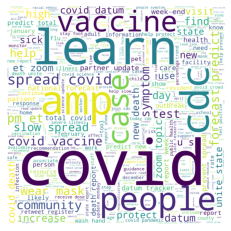

In [13]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, height = 3000, mode ='RGBA', scale=.5).generate(' '.join(tweets_df['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("covid_tweets_word_cloud.pdf", format = 'pdf')

In [14]:
def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [15]:
def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):   
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [16]:
tweets_df['sentences'] = tweets_df['tweet'].apply(lambda x: [word_tokenize(s) for s in sent_tokenize(x)])

In [17]:
def tag_sents_pos(sentences):
    """
    function which replicates NLTK pos tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for token in sent:
            pos_sent.append((token.text, token.tag_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [18]:
tweets_df['POS_sents'] = tweets_df['sentences'].apply(lambda x: tag_sents_pos(x))

In [19]:
#count the number of VB (verbs)
countTarget = 'VB'
targetCounts = {}
for entry in tweets_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
verb_noun_sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
verb_noun_sortedTargets[:20]

[('be', 71),
 ('help', 68),
 ('learn', 51),
 ('protect', 36),
 ('have', 33),
 ('slow', 32),
 ('prevent', 27),
 ('stay', 26),
 ('wear', 23),
 ('spread', 23),
 ('total', 20),
 ('take', 19),
 ('get', 17),
 ('know', 16),
 ('see', 15),
 ('stop', 14),
 ('reduce', 13),
 ('keep', 12),
 ('join', 10),
 ('wash', 10)]

In [20]:
#count the number of NN (nouns)
countTarget = 'NN'
targetCounts = {}
for entry in tweets_df['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
noun_sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
noun_sortedTargets[:20]

[('spread', 100),
 ('amp', 77),
 ('vaccine', 64),
 ('health', 58),
 ('update', 46),
 ('risk', 44),
 ('mask', 40),
 ('week', 37),
 ('report', 35),
 ('call', 35),
 ('community', 29),
 ('pandemic', 28),
 ('contact', 26),
 ('virus', 26),
 ('illness', 25),
 ('cdcs', 24),
 ('zoom', 23),
 ('care', 22),
 ('home', 21),
 ('use', 18)]

In [21]:
def get_modify_word(NTarget, Word):
    NResults = set()
    for entry in tweets_df['POS_sents']:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-2], sentence[2:]):
                if (kind1,ent2.lower())==(NTarget,Word):
                    NResults.add(ent1)
                else:
                    continue
    return NResults

In [22]:
print(get_modify_word("VB", "mask"))
print(get_modify_word("VB", "hands"))
print(get_modify_word("VB", "distance"))
print(get_modify_word("JJ", "zoom"))
print(get_modify_word("VB", ""))

{'put', 'wear', 'position'}
{'wash'}
{'keep'}
{'available'}
set()


In [23]:
#the adjectives that modify the noun
r_jj = {}
for i, v in noun_sortedTargets[:20]:
    #print(i)
    r_jj[i] = get_modify_word("JJ", str(i))
r_jj

{'spread': {'covid', 'likely', 'long', 'rapid', 'slow', 'unlikely'},
 'amp': {'covid', 'key', 'many', 'mental', 'serious', 'sick', 'updated'},
 'vaccine': {'annual', 'covid', 'respiratory', 'variant'},
 'health': {'local', 'national', 'telehealth'},
 'update': set(),
 'risk': {'little'},
 'mask': {'mental'},
 'week': {'public'},
 'report': {'likely'},
 'call': {'next'},
 'community': {'rural'},
 'pandemic': {'covid'},
 'contact': {'covid', 'diagnostic', 'second', 'sick'},
 'virus': {'covid'},
 'illness': {'covid', 'sick'},
 'cdcs': {'covid', 'different', 'new', 'pandemic', 'rural', 'widespread'},
 'zoom': {'available'},
 'care': {'covid', 'long'},
 'home': {'symptomatic'},
 'use': {'available', 'different', 'general', 'similar'}}

In [24]:
#the verbs that modify the noun
r_vb = {}
for i, v in noun_sortedTargets[:20]:
    r_vb[i] = get_modify_word("VB", str(i))
r_vb

{'spread': {'decrease', 'limit', 'lower', 'prevent', 'reduce', 'slow', 'stop'},
 'amp': {'have', 'make', 'protect', 'screen'},
 'vaccine': {'get'},
 'health': set(),
 'update': set(),
 'risk': {'be', 'pose', 'reduce'},
 'mask': {'position', 'put', 'wear'},
 'week': set(),
 'report': {'be', 'collect'},
 'call': {'answer'},
 'community': {'report'},
 'pandemic': {'stop'},
 'contact': {'identify'},
 'virus': {'fight', 'prevent', 'spread'},
 'illness': {'cause', 'have', 'look'},
 'cdcs': {'learn', 'subscribe'},
 'zoom': set(),
 'care': {'get', 'take'},
 'home': {'recover'},
 'use': {'save'}}

In [25]:
def find_part_relation(part1, part2, content):
    NResults = []
    for entry in content:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1 == part1 and kind2 == part2) or  (kind1 == part2 and kind2 == part1):
                    NResults.append([ent1,ent2])
                else:
                    continue
    return NResults
adj_noun_pairs = find_part_relation('JJ','NN',tweets_df['POS_sents'])
adj_noun_pairs[:10]

[['important', 'part'],
 ['certain', 'health'],
 ['bad', 'reaction'],
 ['second', 'dose'],
 ['second', 'dose'],
 ['first', 'appointment'],
 ['new', 'report'],
 ['current', 'vaccine'],
 ['adolescent', 'immunization'],
 ['real', 'world']]

In [26]:
adj_noun_pairs = find_part_relation('VB','NN',tweets_df['POS_sents'])
adj_noun_pairs[:10]

[['cause', 'fever'],
 ['share', 'information'],
 ['ensure', 'access'],
 ['support', 'implementation'],
 ['spread', 'wear'],
 ['mask', 'stay'],
 ['find', 'information'],
 ['week', 'see'],
 ['affect', 'pregnancy'],
 ['amp', 'avoid']]

In [27]:
def find_part_relation(part1, part2, content):
    NResults = []
    for entry in content:
        for sentence in entry:
            for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
                if (kind1 == part1 and kind2 == part2)or  (kind1 == part2 and kind2 == part1):
                    NResults.append([ent1,ent2])
                else:
                    continue
    return NResults
adj_noun_pairs = find_part_relation('VB','RB',tweets_df['POS_sents'])
adj_noun_pairs[:20]

[['get', 'very'],
 ['nt', 'miss'],
 ['nt', 'live'],
 ['not', 'be'],
 ['safely', 'get'],
 ['nt', 'live'],
 ['also', 'continue'],
 ['increase', 'nationwide'],
 ['also', 'remind'],
 ['nt', 'know'],
 ['not', 'require'],
 ['get', 'very'],
 ['sometimes', 'require'],
 ['spread', 'anywhere'],
 ['out', 'wear'],
 ['spread', 'anywhere'],
 ['go', 'out'],
 ['out', 'wear'],
 ['also', 'help'],
 ['nt', 'know']]

In [28]:
#bigrams
tweetsBigrams = nltk.collocations.BigramCollocationFinder.from_words(tweets_df['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(tweetsBigrams.N))

def bigramScoring(count, wordsTuple, total):
    return count

print(tweetsBigrams.nbest(bigramScoring, 10))

There are 8106 bigrams in the finder
[('spread', 'covid'), ('covid', 'vaccine'), ('forecast', 'predict'), ('pm', 'et'), ('wear', 'mask'), ('slow', 'spread'), ('zoom', 'topic'), ('covid', 'datum'), ('et', 'zoom'), ('new', 'death')]


In [29]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
tweetsBigrams.score_ngrams(bigram_measures.likelihood_ratio)[:20]

[(('pm', 'et'), 479.2373580925537),
 (('forecast', 'predict'), 466.4113797544349),
 (('wear', 'mask'), 336.605535283364),
 (('zoom', 'topic'), 316.1086042444233),
 (('u', 's'), 292.37064165023065),
 (('et', 'zoom'), 275.41524757488617),
 (('slow', 'spread'), 263.72834700658706),
 (('unite', 'state'), 245.62745614309722),
 (('retweet', 'register'), 228.92748282183425),
 (('week', 'end'), 227.10839654348368),
 (('wash', 'hand'), 226.7389386813828),
 (('partner', 'update'), 211.42998495881966),
 (('national', 'forecast'), 209.5745361584621),
 (('datum', 'tracker'), 201.854015111622),
 (('predict', 'total'), 194.58415625249245),
 (('avoid', 'crowd'), 167.95751449905924),
 (('update', 'monday'), 154.28672581505407),
 (('spread', 'covid'), 144.77958476332296),
 (('racial', 'ethnic'), 141.53013457408042),
 (('stay', 'foot'), 140.58230707123255)]

In [30]:
[s for s in dir(bigram_measures) if s[0] != '_']

['chi_sq',
 'dice',
 'fisher',
 'jaccard',
 'likelihood_ratio',
 'mi_like',
 'phi_sq',
 'pmi',
 'poisson_stirling',
 'raw_freq',
 'student_t']

In [31]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
tweetsTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(tweets_df['normalized_tokens'].sum())
tweetsTrigrams.score_ngrams(trigram_measures.student_t)[:20]

[(('et', 'zoom', 'topic'), 4.898854620081321),
 (('pm', 'et', 'zoom'), 4.898824349660707),
 (('total', 'covid', 'death'), 4.686687202329723),
 (('report', 'week', 'end'), 4.582123764661537),
 (('death', 'report', 'week'), 4.581349027014161),
 (('covid', 'datum', 'tracker'), 4.579869134637737),
 (('new', 'death', 'report'), 4.5796589511834025),
 (('national', 'forecast', 'predict'), 4.471940550305844),
 (('forecast', 'predict', 'total'), 4.471933812212956),
 (('predict', 'total', 'covid'), 4.469871955789399),
 (('forecast', 'predict', 'new'), 4.35815923783493),
 (('predict', 'new', 'death'), 4.357649662793196),
 (('slow', 'spread', 'covid'), 4.230518531157653),
 (('death', 'unite', 'state'), 3.9995766676291176),
 (('covid', 'death', 'unite'), 3.996502303034022),
 (('partner', 'update', 'monday'), 3.8728893320803093),
 (('prevent', 'spread', 'covid'), 3.8629502057169023),
 (('cdc', 'partner', 'update'), 3.463414890006165),
 (('covid', 'science', 'update'), 3.4621530748628984),
 (('help',

In [32]:
Ngrams = nltk.ngrams(tweets_df['normalized_tokens'].sum(), 4)
Counts = {}
for ngram in list(Ngrams):
    if ngram in Counts.keys():
        Counts[ngram] += 1
    else:
        Counts[ngram] = 1
Filtered = {}
for key in Counts.keys():
    if Counts[key] < 2:
        pass
    else:
        Filtered[key] = Counts[key]
print(Filtered)

{('fever', 'cough', 'shortness', 'breath'): 2, ('use', 'chart', 'learn', 'similarity'): 2, ('chart', 'learn', 'similarity', 'difference'): 2, ('learn', 'covid', 'science', 'update'): 2, ('cdcs', 'new', 'covid', 'datum'): 2, ('new', 'covid', 'datum', 'tracker'): 2, ('covid', 'datum', 'tracker', 'weekly'): 3, ('datum', 'tracker', 'weekly', 'review'): 3, ('protect', 'get', 'sick', 'covid'): 2, ('covid', 'february', 'people', 'receive'): 2, ('february', 'people', 'receive', 'dose'): 3, ('people', 'receive', 'dose', 'covid'): 8, ('receive', 'dose', 'covid', 'vaccine'): 8, ('dose', 'covid', 'vaccine', 'people'): 2, ('covid', 'vaccine', 'people', 'receive'): 2, ('vaccine', 'people', 'receive', 'dose'): 2, ('people', 'receive', 'dose', 'amp'): 2, ('receive', 'dose', 'amp', 'fully'): 2, ('dose', 'amp', 'fully', 'vaccinate'): 2, ('vaccine', 'help', 'protect', 'get'): 2, ('key', 'slow', 'spread', 'covid'): 2, ('slow', 'spread', 'covid', 'public'): 2, ('spread', 'covid', 'public', 'health'): 2, ('

In [33]:

skipgrams = keras.preprocessing.sequence.skipgrams(tweets_df['normalized_tokens'].sum(), 2000, 2,
                                                        negative_samples=0, shuffle=True, 
                                                        categorical=False, sampling_table=None, seed=None)

ModuleNotFoundError: No module named 'keras'

In [ ]:
skip_con = nltk.ConditionalFreqDist(skipgrams[0])
list(skip_con.items())

In [ ]:
def tag_sents_ner(sentences):
    """
    function which replicates NLTK ner tagging on sentences.
    """
    new_sents = []
    for sentence in sentences:
        new_sent = ' '.join(sentence)
        new_sents.append(new_sent)
    final_string = ' '.join(new_sents)
    doc = nlp(final_string)
    
    pos_sents = []
    for sent in doc.sents:
        pos_sent = []
        for ent in sent.ents:
            pos_sent.append((ent.text, ent.label_))
        pos_sents.append(pos_sent)
    
    return pos_sents

In [ ]:
tweets_df['classified_sents'] = tweets_df['sentences'].apply(lambda x: tag_sents_ner(x))

In [ ]:
tweets_df

In [ ]:
entityCounts = {}
for entry in tweets_df['classified_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if ent in entityCounts:
                entityCounts[ent] += 1
            else:
                entityCounts[ent] = 1
sortedEntities = sorted(entityCounts.items(), key = lambda x: x[1], reverse = True)
sortedEntities[:90]

# quarter 1, 2020

In [ ]:
%store -r tweets01

In [ ]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, height = 3000, mode ='RGBA', scale=.5).generate(' '.join(tweets01['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("covid_tweets_01_word_cloud.pdf", format = 'pdf')

# quarter 2, 2020

In [ ]:
%store -r tweets02

In [ ]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, height = 3000, mode ='RGBA', scale=.5).generate(' '.join(tweets02['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("covid_tweets_02_word_cloud.pdf", format = 'pdf')

# quarter 3, 2020

In [ ]:
%store -r tweets03

In [ ]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, height = 3000, mode ='RGBA', scale=.5).generate(' '.join(tweets03['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("covid_tweets_03_word_cloud.pdf", format = 'pdf')

# quarter 4, 2020

In [ ]:
%store -r tweets04

In [ ]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, height = 3000, mode ='RGBA', scale=.5).generate(' '.join(tweets04['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("covid_tweets_04_word_cloud.pdf", format = 'pdf')

# quarter 1, 2021

In [ ]:
%store -r tweets0121

In [ ]:
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 3000, height = 3000, mode ='RGBA', scale=.5).generate(' '.join(tweets0121['normalized_tokens'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("covid_tweets_01_21_word_cloud.pdf", format = 'pdf')